In [1]:
import nimblephysics as nimble
import numpy as np

import time
import torch

from IPython.core.display_functions import clear_output
from einops import einsum, repeat
from scipy.ndimage import median_filter
from torch.onnx.symbolic_opset9 import unsqueeze
from tqdm import tqdm
import matplotlib.pyplot as plt

import theseus as th

import os
import pickle

In [2]:
trial_path = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/S1.b3d"
GEOMETRY_PATH = "/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/Geometry/"
GRAVITY = 9.80665

In [3]:
def plot_histogram(data, bins=10, title="Histogram", xlabel="Value", ylabel="Frequency"):
    """
    Generate and display a histogram from a numerical series with log-scaled frequency.
    """
    data = np.asarray(data).flatten()

    plt.figure(figsize=(20, 10))
    plt.hist(data, bins=bins, edgecolor='black', log=True)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel + " (log scale)")
    plt.grid(True)
    plt.show()


def plot_time_series(values, title="Time Series", xlabel="Time", ylabel="Value"):
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(values.shape[0]), values, linewidth=1.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def columnwise_correlation(A, B):
    A_centered = A - A.mean(axis=0)
    B_centered = B - B.mean(axis=0)

    numerator = np.sum(A_centered * B_centered, axis=0)
    denominator = np.sqrt(np.sum(A_centered**2, axis=0) * np.sum(B_centered**2, axis=0))

    return numerator / denominator  # Shape: (imu,)

# Example:
# A = np.random.randn(100, 17)
# B = np.random.randn(100, 17)
# corr = columnwise_correlation(A, B)


In [4]:
def plot_histogram(data, bins=10, title="Histogram", xlabel="Value", ylabel="Frequency"):
    """
    Generate and display a histogram from a numerical series.

    Parameters:
    - data (array-like): Input series (e.g., list, numpy array, pandas Series)
    - bins (int): Number of histogram bins (default: 10)
    - title (str): Title of the plot
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    """
    # Convert input to a numpy array
    data = np.asarray(data).flatten()

    # Create histogram
    plt.figure(figsize=(20, 10))
    plt.hist(data, bins=bins, edgecolor='black')

    # Add titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Display plot
    plt.grid(True)
    plt.show()


In [5]:
from typing import List
from scipy import signal
from scipy.ndimage import uniform_filter1d
from scipy.spatial.transform import Rotation

import torch


class DIP_Subject:
    def __init__(self, b3d_path):
        self.subject = nimble.biomechanics.SubjectOnDisk(b3d_path)
        self.skeleton = self.subject.readSkel(processingPass=1, geometryFolder=GEOMETRY_PATH)
        self.subject_num = int(b3d_path.split("/")[-1].split(".")[0][1:])
        self.synthetic_component_names = [
            "head",
            "sternum",
            "pelvis",
            "lshoulder",
            "rshoulder",
            "lupperarm",
            "rupperarm",
            "llowerarm",
            "rlowerarm",
            "lupperleg",
            "rupperleg",
            "llowerleg",
            "rlowerleg",
            "lhand",
            "rhand",
            "lfoot",
            "rfoot",
        ]

        # Corresponding bones to the sensors
        self.skel_names = [
            "head",
            "thorax",
            "pelvis",
            "scapula_l",
            "scapula_r",
            "humerus_l",
            "humerus_r",
            "ulna_l",
            "ulna_r",
            "femur_l",
            "femur_r",
            "tibia_l",
            "tibia_r",
            "hand_l",
            "hand_r",
            "calcn_l",
            "calcn_r"
        ]

        self.N_MEAS = len(self.skel_names) * 3

        self.imus = [(self.skeleton.getBodyNode(name), nimble.math.Isometry3.Identity()) for name in self.skel_names]

        self.corresponding_imu_path = os.path.join(os.path.dirname(b3d_path), f"DIP_orig/S{self.subject_num}")
        self.trial_map = {}
        self.joint_data_map = {}
        self.trial_imu_map = {}
        # self.skeleton.setGravity([0, -GRAVITY, 0])
        self.skeleton.setGravity([0, 0, 0])
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"Processing DIP Subject {self.subject_num}")


        # Creating a map between a trial for some subject and the corresponding frame list
        for i in range(self.subject.getNumTrials()):
            key = self.subject.getTrialOriginalName(i).split("_")[0]
            curr_trial = self.subject.readFrames(trial=i,
                                                 startFrame=0,
                                                 numFramesToRead=self.subject.getTrialLength(i),
                                                 includeProcessingPasses=True)

            if key in self.trial_map:
                self.trial_map[key].extend(curr_trial)
            else:
                self.trial_map[key] = curr_trial

        # Define Butterworth filter parameters
        self.fs = 60  # Sampling frequency
        self.cutoff =  8  # Cutoff frequency
        self.b, self.a = signal.butter(10, self.cutoff / (self.fs / 2), btype='low')

        # Creating a map for joint state
        for key, frames in self.trial_map.items():
            joint_angles_raw = np.vstack([frame.processingPasses[0].pos for frame in frames]).T
            joint_vel_raw = np.vstack([frame.processingPasses[0].vel for frame in frames]).T
            joint_acc_raw = np.vstack([frame.processingPasses[0].acc for frame in frames]).T

            # bins = 50
            # plot_histogram(joint_vel_raw.copy(), bins=bins, title="Joint Velocity", xlabel="rad/s")
            # plot_histogram(joint_acc_raw.copy(), bins=bins, title="Joint Acceleration", xlabel="rad/s^2")

            # print(f"Invalid joint velocities {np.sum(np.abs(joint_vel_raw) > 105)}")
            # print(f"Invalid joint accelerations {np.sum(np.abs(joint_acc_raw) > 6000)}")

            # plot_time_series(joint_vel_raw[0, :], title=key)

            self.joint_data_map[key] = {
                "joint_angles": signal.filtfilt(self.b, self.a, joint_angles_raw, axis=1),
                "joint_vel": signal.filtfilt(self.b, self.a, joint_vel_raw, axis=1),
                "joint_acc": signal.filtfilt(self.b, self.a, joint_acc_raw, axis=1),
            }


            """
            self.filter = (1, 8)
            self.joint_data_map[key] = {
                "joint_angles": joint_angles_raw,
                "joint_vel": uniform_filter1d(median_filter(joint_vel_raw, size=self.filter), size=100, axis=1),
                "joint_acc": uniform_filter1d(median_filter(joint_acc_raw, size=self.filter), size=100, axis=1),
            }
            """

            with open(os.path.join(self.corresponding_imu_path, f"{key}.pkl"), "rb") as file:
                real_data = pickle.load(file, encoding="latin1")["imu"]
                acc = real_data[:, :, 9:12]
                acc = self.fill_nans(acc)

            self.num_trials = len(self.joint_data_map.keys())

            self.trial_imu_map[key] = {
                "acc": acc,
            }

            # plot_time_series(np.linalg.norm(acc[: , 0, :], axis=-1), title=key)

        self.syn_imu = {}
        self.get_syn_imu_to_real_transformations()


        for trial, curr_imu in self.syn_imu.items():
            real_acc_normed = np.linalg.norm(self.trial_imu_map[trial]["acc"], axis=-1)
            syn_acc_normed = np.linalg.norm(curr_imu["acc"], axis=-1)
            correlation = columnwise_correlation(real_acc_normed, syn_acc_normed)
            avg_corr = np.mean(correlation)

            print(f"Trial {trial} : {avg_corr}\n{correlation}")

        self.opt_trans = {}
        self.find_optimal_syn_transformations()


        gui = nimble.NimbleGUI()
        gui.serve(8080)

        def renderBasis(key, p, R, colors: List[List[float]] = None):
            if colors is None:
                colors = [[1., 0., 0., 1.], [0., 1., 0., 1.], [0., 0., 1., 1.]]

            gui.nativeAPI().createLine(key + '_x', [p, R[:, 0] / 10 + p], colors[0], width=[1.])
            gui.nativeAPI().createLine(key + '_y', [p, R[:, 1] / 10 + p], colors[1], width=[1.])
            gui.nativeAPI().createLine(key + '_z', [p, R[:, 2] / 10 + p], colors[2], width=[1.])

        transform_dict = self.opt_trans["03"]

        for t in tqdm(range(self.joint_data_map["03"]["joint_angles"].shape[1])):
            self.skeleton.setPositions(self.joint_data_map["03"]["joint_angles"][:, t])

            for imu_num in range(len(self.skel_names)):
                # Shape: (Sequence Length) x (IMUs) x (Rows) x (Cols)
                body_node_in_world = transform_dict["world_to_body_node"]

                # Shape: (IMUs) x (Rows) x (Cols)
                imu_in_body_node = transform_dict["body_node_to_imu"]

                # Grab the heads
                body_node_in_world = body_node_in_world[t, imu_num, :, :]
                imu_in_body_node = imu_in_body_node[imu_num, :, :]

                imu_in_world_frame = body_node_in_world @ imu_in_body_node

                renderBasis(key=f"imu number {imu_num}", p=imu_in_world_frame[:-1, -1], R=imu_in_world_frame[:-1, :-1])


            # print(gravity_direction)
            gui.nativeAPI().renderSkeleton(self.skeleton)
            time.sleep(1/60)


    # Get estimated homogenous transformations from synthetix to real imu
    def get_syn_imu_to_real_transformations(self):
        for trial_name, trial in self.joint_data_map.items():
            joint_angles = trial["joint_angles"]
            joint_vel = trial["joint_vel"]
            joint_acc = trial["joint_acc"]

            curr_syn_acc = np.empty((self.N_MEAS,  joint_angles.shape[1]))
            curr_syn_angular_vel = np.empty((self.N_MEAS,  joint_angles.shape[1]))

            for t in range(joint_angles.shape[1]):
                self.skeleton.setPositions(joint_angles[:, t])
                self.skeleton.setVelocities(joint_vel[:, t])
                self.skeleton.setAccelerations(joint_acc[:, t])

                curr_syn_acc[:, t] = self.skeleton.getAccelerometerReadings(self.imus)
                curr_syn_angular_vel[:, t] = self.skeleton.getGyroReadings(self.imus)


            curr_syn_acc = curr_syn_acc.T.reshape(-1, 17, 3)
            curr_syn_angular_vel = curr_syn_angular_vel.T.reshape(-1, 17, 3)

            curr_syn_angular_accel = np.zeros_like(curr_syn_angular_vel)

            curr_syn_angular_accel[1:-1] = (curr_syn_angular_vel[2:] - curr_syn_angular_vel[:-2]) / (2/60)
            curr_syn_angular_accel[0] = (curr_syn_angular_vel[1] - curr_syn_angular_vel[0]) / (1/60)  # Forward difference for the first element
            curr_syn_angular_accel[-1] = (curr_syn_angular_vel[-1] - curr_syn_angular_vel[-2]) / (1/60) # Backward difference for the last element

            """
            for i in range(3):
                plt.figure(figsize=(8, 4))
                plt.plot(np.arange(curr_syn_acc.shape[0]), curr_syn_acc[:, 0, i], label=f"Element {i}")

                plt.xlabel("Time")
                plt.ylabel(f"Value (Depth {i})")
                plt.title(f"Time Series for Depth {i}")
                plt.legend()
                plt.grid()

                plt.show()

            """


            self.syn_imu[trial_name] = {"acc": curr_syn_acc, "angular_vel": curr_syn_angular_vel, "angular_accel": curr_syn_angular_accel}

    def fill_nans(self, acc):
        # Reshape (T, N, C) -> (T, N*C) for simpler 1D column-wise interpolation
        T, N, C = acc.shape
        acc_2d = acc.reshape(T, N * C)

        for col_idx in range(acc_2d.shape[1]):
            col_data = acc_2d[:, col_idx]
            # Find indices of valid and invalid entries
            valid_mask = ~np.isnan(col_data)
            if not np.any(valid_mask):
                col_data[:] = 0.0
                continue
            if np.all(valid_mask):
                continue

            valid_x = np.where(valid_mask)[0]
            valid_y = col_data[valid_mask]
            invalid_x = np.where(~valid_mask)[0]

            # Interpolate
            col_data[invalid_x] = np.interp(invalid_x, valid_x, valid_y)

        acc_filled = acc_2d.reshape(T, N, C)
        return acc_filled

    def get_world_transforms(self, trial_name):
        num_time_steps = self.joint_data_map[trial_name]["joint_angles"].shape[1]
        world_transform = np.empty((num_time_steps, 17, 4, 4))


        for t in range(num_time_steps):
            self.skeleton.setPositions(self.joint_data_map[trial_name]["joint_angles"][:, t])

            for idx, body_node_name in enumerate(self.skel_names):
                world_transform[t, idx, :, :] = self.skeleton.getBodyNode(body_node_name).getWorldTransform().matrix()

        return world_transform

    def find_optimal_syn_transformations(self):
        for trial_name, syn_imu in self.syn_imu.items():
            # Convert numpy arrays to PyTorch tensors
            num_t_steps = syn_imu["acc"].shape[0]
            losses = []

            real_imu_data = torch.tensor(self.trial_imu_map[trial_name]["acc"], device=self.device, dtype=torch.float32)
            syn_imu_data = torch.tensor(syn_imu["acc"], device=self.device, dtype=torch.float32)
            syn_imu_angular_vel_data = torch.tensor(syn_imu["angular_vel"], device=self.device, dtype=torch.float32)
            syn_imu_angular_accel_data = torch.tensor(syn_imu["angular_accel"], device=self.device, dtype=torch.float32)

            real_imu_normed = torch.linalg.norm(real_imu_data, dim=-1)
            syn_imu_data_normed  = torch.linalg.norm(syn_imu_data, dim=-1)

            high_signal_filter = (real_imu_normed < 10) & (syn_imu_data_normed < 10)
            high_signal_filter = high_signal_filter.float().detach().unsqueeze(-1)


            trial_body_node_world_transforms = torch.tensor(self.get_world_transforms(trial_name), device=self.device, dtype=torch.float32)


            radius_mat = torch.rand(17, 3, dtype=torch.float32, device=self.device).requires_grad_()
            unnormed_quaternions = torch.rand(17, 4, dtype=torch.float32, device=self.device).requires_grad_()

            optimizer = torch.optim.AdamW([{'params': [radius_mat], 'weight_decay': 0},
                                           {'params': [unnormed_quaternions], 'weight_decay': 0}
            ], lr=1e-2)


            for iteration in range(700):
                optimizer.zero_grad()

                current_quaternions = unnormed_quaternions / torch.norm(unnormed_quaternions, dim=-1, keepdim=True)
                rotation_transforms = th.SO3(quaternion=current_quaternions).to_matrix()

                radius_mat_batched = repeat(
                    radius_mat,
                    "imu c -> seq imu c",
                    seq=syn_imu_data.shape[0]
                )

                # Synthetic and Real Angular Acceleration and Velocity will be nearly the same
                real_imu_linear_accel = torch.linalg.cross(syn_imu_angular_accel_data, radius_mat_batched, dim = -1)
                real_imu_velocity = torch.linalg.cross(syn_imu_angular_vel_data, radius_mat_batched, dim = -1)
                real_imu_centripetal_accel = torch.linalg.cross(syn_imu_angular_vel_data, real_imu_velocity, dim = -1)

                real_imu_in_syn_frame = einsum(rotation_transforms, real_imu_data, "imu i j, seq imu i -> seq imu j") + real_imu_linear_accel + real_imu_centripetal_accel

                residual = real_imu_in_syn_frame - syn_imu_data
                loss = torch.norm(residual * high_signal_filter, p=1, dim=-1).mean()

                losses.append(loss.item())
                loss.backward()
                optimizer.step()


            unnormed_quaternions = unnormed_quaternions.detach().cpu()
            current_quaternions = unnormed_quaternions / torch.norm(unnormed_quaternions, dim=-1, keepdim=True)

            radius_mat_numpy = radius_mat.detach().cpu()

            self.opt_trans[trial_name] = {
                "body_node_to_imu": th.SE3(x_y_z_quaternion=torch.cat([-radius_mat_numpy, current_quaternions], dim=-1), dtype=torch.float32).to_matrix().detach().cpu().numpy(),
                "world_to_body_node": trial_body_node_world_transforms.detach().cpu().numpy(),
                "losses": losses
            }

            plt.figure(figsize=(8, 5))
            plt.plot(np.arange(len(losses)), losses, label="Training Loss", marker="o", linestyle="-", markersize=4)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Loss vs. Epochs")
            plt.legend()
            plt.grid(True)
            plt.show()

Setting len to 0.106608
Setting neutral pos to   0
0.7
  0
Setting len to 0.342794
Setting neutral pos to    0
-0.6
   0
Setting len to 0.119716
Setting neutral pos to   0
0.2
  0
Processing DIP Subject 1
Trial 01 : 0.17666277512731976
[4.41455392e-03 4.08330739e-02 5.16972026e-04 1.76091023e-01
 1.71996833e-01 2.37382777e-01 2.33571609e-01 9.63110753e-02
 6.05797101e-01 3.36337525e-02 2.21779750e-02 1.87715578e-01
 8.64079547e-02 1.03358191e-01 8.66455109e-01 6.84606689e-02
 6.81429303e-02]
Trial 02 : 0.1522134242506481
[0.14219762 0.15276612 0.07672295 0.10852357 0.13416403 0.11700434
 0.1416585  0.1257689  0.15186345 0.0853285  0.13311903 0.14364927
 0.29195785 0.20790871 0.12836426 0.20711579 0.23951532]
Trial 03 : 0.05707205473456613
[0.02788864 0.03469915 0.21591567 0.02496344 0.03886431 0.01705159
 0.04749054 0.00349944 0.04744964 0.07742402 0.02902156 0.18734357
 0.0908171  0.00539228 0.04072037 0.05514666 0.02653695]
Trial 04 : 0.6353389983483266
[0.49951794 0.48143371 0.55670

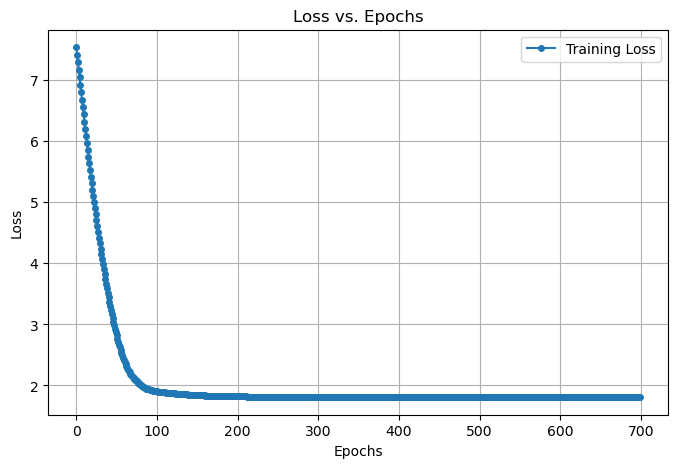

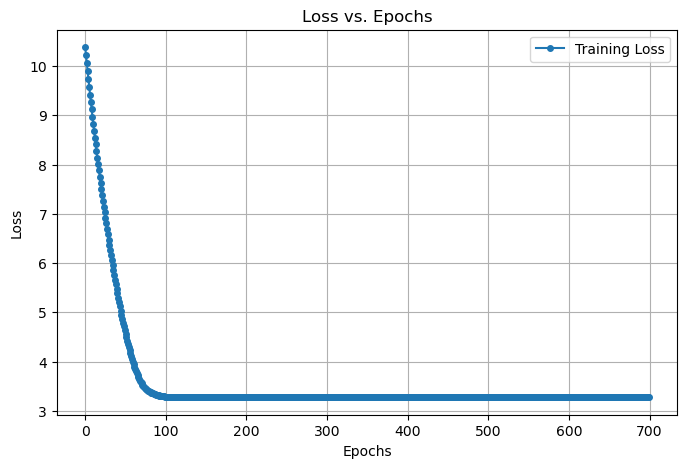

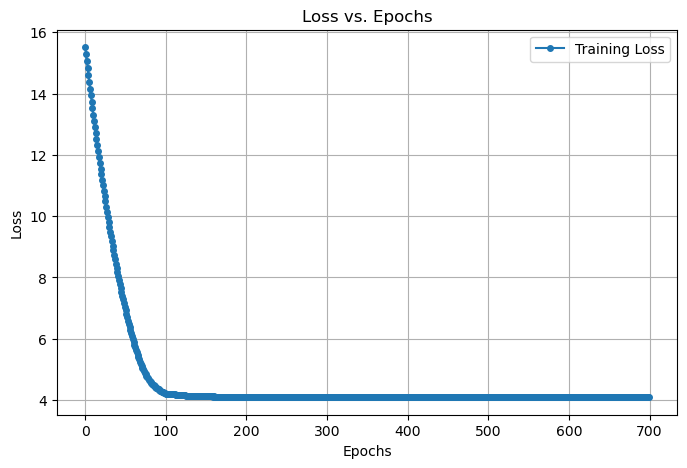

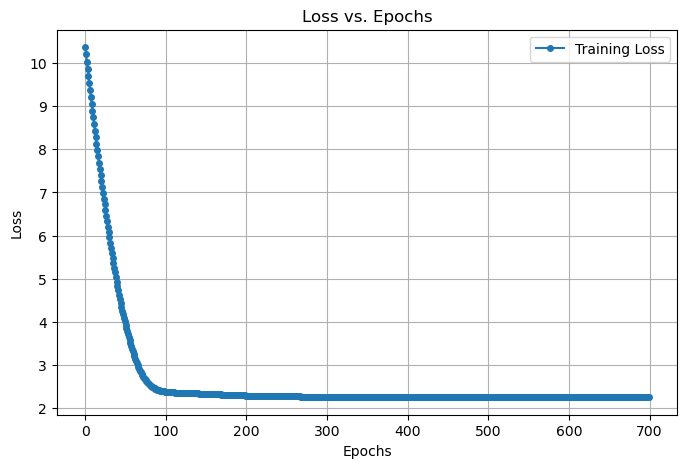

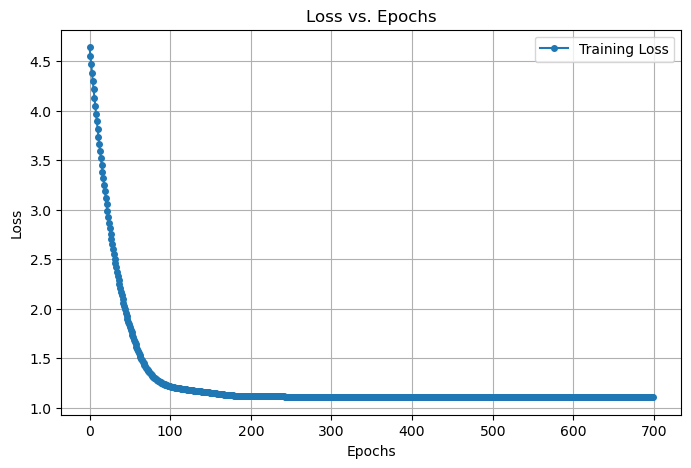

GUIWebsocketServer will start serving a WebSocket server on ws://localhost:8070
Web GUI serving on http://localhost:8080


 47%|████▋     | 3743/7938 [01:10<01:18, 53.47it/s]


KeyboardInterrupt: 

In [6]:
dip_subject = DIP_Subject(trial_path)

In [7]:
import pickle
with open("/home/meribejayson/Desktop/Projects/realistic-imu/data/final_dataset/DIP/DIP_orig/S1/01.pkl", "rb") as file:
    loaded_dict = pickle.load(file, encoding="latin1")

loaded_dict.keys()

dict_keys(['gt', 'imu_acc', 'sop', 'sip', 'imu', 'imu_ori'])

In [8]:
loaded_dict['gt'].shape

(13778, 72)

In [9]:
loaded_dict["imu"].shape

(13778, 17, 12)

In [10]:
loaded_dict["imu_acc"].shape

(13778, 17, 3)

In [11]:
loaded_dict["imu_ori"].shape

(13778, 17, 3, 3)

In [12]:
np.array(loaded_dict["imu"])

array([[[ 8.99958426e-01, -1.52170610e-01, -4.08557141e-01, ...,
          2.87727400e-01, -3.21206600e-02,  2.75293900e-01],
        [ 9.86486380e-01, -1.18945156e-02,  1.63410962e-01, ...,
         -1.02876600e-01, -2.09811600e-01,  5.44532100e-02],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-1.49201524e-01, -9.59130270e-01,  2.40433004e-01, ...,
         -1.76260800e-01, -4.97950800e-01, -6.74201400e-01],
        [ 9.71572888e-01,  8.98731082e-02,  2.19018147e-01, ...,
         -2.49178900e-03, -8.40159400e-02, -2.36664100e-02],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 9.02916654e-01, -1.50426668e-01, -4.02633001e-01, ...,
          5.44843000e-01,  2.00419600e-01,  1.55229900e-02],
        [ 9.86494438e-01, -1.16640835e-02,  1.63378925e-01, ...,
         -3.04211200e-02, -1.44157800e

In [13]:
import pandas as pd

imu_data = pd.DataFrame(loaded_dict["imu"][:, 0, :])
imu_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.899958,-0.152171,-0.408557,0.110105,0.986062,-0.124732,0.421843,0.067269,0.904170,0.287727,-0.032121,0.275294
1,0.902917,-0.150427,-0.402633,0.109236,0.986310,-0.123528,0.415703,0.067554,0.906988,0.544843,0.200420,0.015523
2,0.907106,-0.147775,-0.394108,0.108318,0.986764,-0.120684,0.406725,0.066785,0.911106,0.424359,-0.016825,0.526527
3,0.912280,-0.144131,-0.383368,0.106024,0.987234,-0.118860,0.395606,0.067787,0.915915,0.483116,-0.234759,0.824544
4,0.917959,-0.140608,-0.370919,0.103391,0.987558,-0.118491,0.382965,0.070421,0.921075,0.327068,-0.238826,0.923633
...,...,...,...,...,...,...,...,...,...,...,...,...
13773,0.916335,0.036234,0.398770,0.016452,0.991649,-0.127911,-0.400074,0.123770,0.908087,0.041399,-0.151680,-0.006429
13774,0.916223,0.036525,0.399001,0.016083,0.991681,-0.127711,-0.400346,0.123429,0.908013,-0.054725,-0.140453,0.039699
13775,0.916032,0.036864,0.399408,0.015669,0.991719,-0.127469,-0.400800,0.123024,0.907868,-0.103108,-0.127536,0.062516
13776,0.915774,0.037119,0.399975,0.015401,0.991745,-0.127299,-0.401398,0.122737,0.907642,-0.124140,-0.143370,0.104146


In [14]:
imu_data = pd.DataFrame(loaded_dict["imu_acc"][:, 0, :])

imu_data

,0,1,2
0,0.287727,-0.032121,0.275294
1,0.544843,0.200420,0.015523
2,0.424359,-0.016825,0.526527
3,0.483116,-0.234759,0.824544
4,0.327068,-0.238826,0.923633
...,...,...,...
13773,0.041399,-0.151680,-0.006429
13774,-0.054725,-0.140453,0.039699
13775,-0.103108,-0.127536,0.062516
13776,-0.124140,-0.143370,0.104146
